# Setup environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import copy
import pathlib

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

try:
    import lightgbm as lgb
except:
    print("lightgbm is not installed")

DATA_DIR = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/merged-data/by-station"
STATION_IDS = [211, 212, 213, 214, 215, 216]

LIGHTGBM_DIR = f"/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/{datetime.now(timezone('Asia/Saigon')).strftime('%Y_%m_%d-%H_%M_%S')}"
pathlib.Path(LIGHTGBM_DIR).mkdir(parents=True, exist_ok=True)
print(LIGHTGBM_DIR)

BASE_FEATURE_COLS = [
    "NO2_quantrac",
    "PM25_quantrac",
    "O3_quantrac",
    "CO_quantrac",
    "Temperature_quantrac",
    "Humid_quantrac",
    "SO2_quantrac",
]

# Define lag and rolling windows for feature engineering
LAG_STEPS = [1, 2, 3, 6, 12, 24, 48, 72]
#ROLL_WINDOWS = [3, 6, 12, 24]
ROLL_WINDOWS = [3, 6, 12, 24, 48, 72]

# Define horizon (= n_past = n_future)
HORIZONS = [1, 24, 48, 72]

RANDOM_STATE = 42

/le_thanh_van_118/workspace/hiep_workspace/lightgbm_results/2025_12_04-14_38_52


# Load dataset

In [2]:
def load_station_csv(station_id, data_dir=DATA_DIR):
    csv_path = os.path.join(data_dir, f"{station_id}.csv")
    df = pd.read_csv(csv_path)

    # Convert to datetime
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)

    # Remove unncessary column
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    # Add station_id column
    df["station_id"] = station_id
    return df

# Load dataset
dfs = []
for sid in STATION_IDS:
    df_sid = load_station_csv(sid, DATA_DIR)
    dfs.append(df_sid)
df_all = pd.concat(dfs, ignore_index=True)

# Sort data by station then date
df_all = df_all.sort_values(["station_id", "date"]).reset_index(drop=True)

# Remove uncessary features
df_all = df_all.loc[:, ["date"] + BASE_FEATURE_COLS + ["station_id"]]

print(df_all.shape)
print(df_all.columns)
df_all

(92966, 9)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'station_id'],
      dtype='object')


,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,station_id
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,28.361905,63.188095,NaN,211
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,28.320588,63.773529,NaN,211
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,28.336667,64.205000,NaN,211
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,28.305000,64.735000,NaN,211
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,28.300000,65.188333,NaN,211
...,...,...,...,...,...,...,...,...,...
92961,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,27.690000,67.290000,0.105667,216
92962,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,27.401667,68.026667,0.104167,216
92963,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,27.603333,66.965000,0.130167,216
92964,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,27.036667,63.361667,0.075833,216


# Data preparation

## Functions to feature engineering

In [3]:
def add_time_features(df, time_col="date"):
    df = df.copy()
    df["hour"] = df[time_col].dt.hour
    df["dayofweek"] = df[time_col].dt.dayofweek
    df["month"] = df[time_col].dt.month
    return df

# Add lag features for all FEATURES including LABEL
def add_lag_features(df, group_col, target_cols, lag_steps):
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for lag in lag_steps:
            df[f"{col}_lag{lag}"] = df.groupby(group_col)[col].shift(lag)
    return df

# Just add the rolling features for LABEL
def add_rolling_features(df, group_col, target_cols, windows):
    assert isinstance(target_cols, list), "target_cols should be a list"

    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    for col in target_cols:
        for w in windows:
            df[f"{col}_roll{w}_mean"] = (
                df.groupby(group_col)[col]
                  .shift(1) # use the past, avoid leaking
                  .rolling(window=w, min_periods=1)
                  .mean()
                  .reset_index(level=0, drop=True)
            )
            df[f"{col}_roll{w}_std"] = (
                df.groupby(group_col)[col]
                  .shift(1)
                  .rolling(window=w, min_periods=1)
                  .std()
                  .reset_index(level=0, drop=True)
            )
    return df

# Add time features and lag feature for all gases
df_all = add_time_features(df_all)
df_all = add_lag_features(df_all, group_col="station_id", target_cols=BASE_FEATURE_COLS, lag_steps=LAG_STEPS)

# Example to add rolling features with no2 gases
test = add_rolling_features(df_all, group_col="station_id", target_cols=["NO2_quantrac"], windows=ROLL_WINDOWS)
print(test.shape)
print(test.columns)
test

(92966, 80)
Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'station_id',
       'hour', 'dayofweek', 'month', 'NO2_quantrac_lag1', 'NO2_quantrac_lag2',
       'NO2_quantrac_lag3', 'NO2_quantrac_lag6', 'NO2_quantrac_lag12',
       'NO2_quantrac_lag24', 'NO2_quantrac_lag48', 'NO2_quantrac_lag72',
       'PM25_quantrac_lag1', 'PM25_quantrac_lag2', 'PM25_quantrac_lag3',
       'PM25_quantrac_lag6', 'PM25_quantrac_lag12', 'PM25_quantrac_lag24',
       'PM25_quantrac_lag48', 'PM25_quantrac_lag72', 'O3_quantrac_lag1',
       'O3_quantrac_lag2', 'O3_quantrac_lag3', 'O3_quantrac_lag6',
       'O3_quantrac_lag12', 'O3_quantrac_lag24', 'O3_quantrac_lag48',
       'O3_quantrac_lag72', 'CO_quantrac_lag1', 'CO_quantrac_lag2',
       'CO_quantrac_lag3', 'CO_quantrac_lag6', 'CO_quantrac_lag12',
       'CO_quantrac_lag24', 'CO_quantrac_lag48', 'CO_quantrac_lag72',
       'Temperature_quantrac_lag1', 'Tempera

,date,NO2_quantrac,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,station_id,hour,...,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std,NO2_quantrac_roll48_mean,NO2_quantrac_roll48_std,NO2_quantrac_roll72_mean,NO2_quantrac_roll72_std
0,2021-02-23 21:00:00,112.740762,15.604762,55.431381,90.000000,28.361905,63.188095,NaN,211,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-23 22:00:00,112.366471,14.594118,58.197176,1200.603529,28.320588,63.773529,NaN,211,22,...,112.740762,NaN,112.740762,NaN,112.740762,NaN,112.740762,NaN,112.740762,NaN
2,2021-02-23 23:00:00,112.700433,13.436667,55.029433,1177.897000,28.336667,64.205000,NaN,211,23,...,112.553616,0.264664,112.553616,0.264664,112.553616,0.264664,112.553616,0.264664,112.553616,0.264664
3,2021-02-24 00:00:00,112.480867,12.365000,54.767700,90.000000,28.305000,64.735000,NaN,211,0,...,112.602555,0.205447,112.602555,0.205447,112.602555,0.205447,112.602555,0.205447,112.602555,0.205447
4,2021-02-24 01:00:00,114.331500,11.636667,53.786200,90.000000,28.300000,65.188333,NaN,211,1,...,112.572133,0.178441,112.572133,0.178441,112.572133,0.178441,112.572133,0.178441,112.572133,0.178441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92961,2022-12-31 19:00:00,0.088233,41.450000,75.916667,2.087167,27.690000,67.290000,0.105667,216,19,...,0.067444,0.013529,0.069522,0.010453,0.072869,0.012924,0.079129,0.013959,0.079666,0.017799
92962,2022-12-31 20:00:00,0.083217,50.530000,66.116667,2.006500,27.401667,68.026667,0.104167,216,20,...,0.073336,0.013617,0.070565,0.011680,0.072782,0.012808,0.079045,0.013890,0.079576,0.017739
92963,2022-12-31 21:00:00,0.084300,55.055000,55.133333,2.418833,27.603333,66.965000,0.130167,216,21,...,0.077625,0.011516,0.071129,0.012144,0.072421,0.012361,0.078764,0.013660,0.079133,0.017229
92964,2022-12-31 22:00:00,0.066650,26.078333,46.750000,1.481500,27.036667,63.361667,0.075833,216,22,...,0.081708,0.007614,0.071817,0.012670,0.072130,0.011973,0.078463,0.013366,0.078738,0.016767


## Functions to prepare data for training

In [4]:
# Reframe past future
def build_supervised_for_horizon(df, horizon_h, target_col):
    # Sort data by station_id then date
    df = df.copy()
    df = df.sort_values(["station_id", "date"])

    # Define name of target column
    target_name = f"{target_col}_t_plus_{horizon_h}h"

    # Mục tiêu: NO2 tại tương lai t+h
    df[target_name] = df.groupby("station_id")[target_col].shift(-horizon_h)

    # Define feature columns
    ignore_cols = ["date", target_col, target_name]
    feature_cols = [c for c in df.columns if c not in ignore_cols]

    # Remove duplicated columns (if possible)
    feature_cols = list(dict.fromkeys(feature_cols))

    # Do not use station_id as feature
    feature_cols_no_sid = [c for c in feature_cols if c != "station_id"]
    data = df[["date", "station_id"] + feature_cols_no_sid + [target_name]].dropna()

    X = data[feature_cols_no_sid]
    y = data[target_name]
    meta = data[["date", "station_id"]]

    return X, y, meta, feature_cols_no_sid

# Example
X_h1, y_h1, meta_h1, feat_cols = build_supervised_for_horizon(test, horizon_h=1, target_col="NO2_quantrac")
print("Horizon 1h:", X_h1.shape, y_h1.shape)
print(X_h1.columns)
display(X_h1)
display(y_h1)

Horizon 1h: (6449, 77) (6449,)
Index(['PM25_quantrac', 'O3_quantrac', 'CO_quantrac', 'Temperature_quantrac',
       'Humid_quantrac', 'SO2_quantrac', 'hour', 'dayofweek', 'month',
       'NO2_quantrac_lag1', 'NO2_quantrac_lag2', 'NO2_quantrac_lag3',
       'NO2_quantrac_lag6', 'NO2_quantrac_lag12', 'NO2_quantrac_lag24',
       'NO2_quantrac_lag48', 'NO2_quantrac_lag72', 'PM25_quantrac_lag1',
       'PM25_quantrac_lag2', 'PM25_quantrac_lag3', 'PM25_quantrac_lag6',
       'PM25_quantrac_lag12', 'PM25_quantrac_lag24', 'PM25_quantrac_lag48',
       'PM25_quantrac_lag72', 'O3_quantrac_lag1', 'O3_quantrac_lag2',
       'O3_quantrac_lag3', 'O3_quantrac_lag6', 'O3_quantrac_lag12',
       'O3_quantrac_lag24', 'O3_quantrac_lag48', 'O3_quantrac_lag72',
       'CO_quantrac_lag1', 'CO_quantrac_lag2', 'CO_quantrac_lag3',
       'CO_quantrac_lag6', 'CO_quantrac_lag12', 'CO_quantrac_lag24',
       'CO_quantrac_lag48', 'CO_quantrac_lag72', 'Temperature_quantrac_lag1',
       'Temperature_quantrac_lag2'

,PM25_quantrac,O3_quantrac,CO_quantrac,Temperature_quantrac,Humid_quantrac,SO2_quantrac,hour,dayofweek,month,NO2_quantrac_lag1,...,NO2_quantrac_roll6_mean,NO2_quantrac_roll6_std,NO2_quantrac_roll12_mean,NO2_quantrac_roll12_std,NO2_quantrac_roll24_mean,NO2_quantrac_roll24_std,NO2_quantrac_roll48_mean,NO2_quantrac_roll48_std,NO2_quantrac_roll72_mean,NO2_quantrac_roll72_std
84278,15.130000,43.433333,0.624833,29.078333,62.088333,0.050500,0,1,1,0.063250,...,0.066033,0.006117,0.057625,0.012378,0.065115,0.012229,0.062968,0.013749,0.065661,0.014454
84279,12.840000,52.400000,0.642167,28.348333,85.075000,0.050667,1,1,1,0.061917,...,0.063647,0.003629,0.059007,0.011793,0.064784,0.012202,0.062702,0.013641,0.065563,0.014456
84280,9.021667,46.983333,0.363500,27.545000,80.896667,0.024000,2,1,1,0.075300,...,0.065308,0.006037,0.061811,0.011281,0.065159,0.012387,0.062904,0.013756,0.065645,0.014494
84281,7.460000,66.366667,0.322833,24.828333,93.530000,0.019167,3,1,1,0.059317,...,0.063528,0.005952,0.062094,0.011162,0.064624,0.012349,0.062781,0.013761,0.065518,0.014509
84282,6.306667,68.300000,0.512667,25.085000,95.483333,0.030000,4,1,1,0.077950,...,0.066236,0.008219,0.065560,0.008612,0.065071,0.012638,0.062989,0.013916,0.065632,0.014575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92960,36.641667,85.600000,1.471500,28.181667,64.298333,0.068667,18,5,12,0.081400,...,0.062992,0.010096,0.068324,0.009109,0.072597,0.012699,0.079356,0.014162,0.079769,0.017859
92961,41.450000,75.916667,2.087167,27.690000,67.290000,0.105667,19,5,12,0.086167,...,0.067444,0.013529,0.069522,0.010453,0.072869,0.012924,0.079129,0.013959,0.079666,0.017799
92962,50.530000,66.116667,2.006500,27.401667,68.026667,0.104167,20,5,12,0.088233,...,0.073336,0.013617,0.070565,0.011680,0.072782,0.012808,0.079045,0.013890,0.079576,0.017739
92963,55.055000,55.133333,2.418833,27.603333,66.965000,0.130167,21,5,12,0.083217,...,0.077625,0.011516,0.071129,0.012144,0.072421,0.012361,0.078764,0.013660,0.079133,0.017229


84278    0.075300
84279    0.059317
84280    0.077950
84281    0.087883
84282    0.080567
           ...   
92960    0.088233
92961    0.083217
92962    0.084300
92963    0.066650
92964    0.067783
Name: NO2_quantrac_t_plus_1h, Length: 6449, dtype: float64

In [5]:
def train_test_validation_split(X, y, meta, train_ratio=0.7, val_ratio=0.15):
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))

    X_train = X.iloc[:train_end]
    y_train = y.iloc[:train_end]
    meta_train = meta.iloc[:train_end]

    X_val = X.iloc[train_end:val_end]
    y_val = y.iloc[train_end:val_end]
    meta_val = meta.iloc[train_end:val_end]

    X_test = X.iloc[val_end:]
    y_test = y.iloc[val_end:]
    meta_test = meta.iloc[val_end:]

    return (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test)

## Functions to calculate metrics

In [6]:
def compute_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Mean Bias Error
    mbe = np.mean(y_pred - y_true)

    # MNBE
    yt_nonzero = np.where(y_true == 0, np.nan, y_true)
    mnbe = np.nanmean((y_pred - yt_nonzero) / yt_nonzero) * 100.0

    # Pearson r (with standard deviation check)
    if np.std(y_true) < 1e-6 or np.std(y_pred) < 1e-6:
        r = np.nan
    else:
        r = np.corrcoef(y_true, y_pred)[0, 1]

    return {
        "RMSE": rmse,
        "MAE": mae,
        "MBE": mbe,
        "MNBE": mnbe,
        "r": r,
        "n_samples": len(y_true),
    }

# LightGBM model

## Functions for training model

In [7]:
def train_lgbm_for_horizon(df_feat,
                           horizon_h,
                           target_col,
                           learning_rate=0.05,
                           n_estimators=2000,
                           early_stopping_rounds=100):

    # Build supervised dataset
    X, y, meta, feature_cols = build_supervised_for_horizon(df_feat, horizon_h=horizon_h, target_col=target_col)

    # Split train validation test
    (X_train, y_train, meta_train, X_val, y_val, meta_val, X_test, y_test, meta_test) = train_test_validation_split(X, y, meta)

    # Dataset cho LightGBM
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": learning_rate,
        "num_leaves": 63,
        "feature_fraction": 0.9,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "verbosity": -1,
        "device": "cuda",
        "seed": RANDOM_STATE,
    }

    # Early stopping dùng callback (tương thích nhiều version LightGBM)
    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds),
        lgb.log_evaluation(period=100),
    ]
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=n_estimators,
        valid_sets=[lgb_train, lgb_val],
        valid_names=["train", "val"],
        callbacks=callbacks,
    )

    # Prediction
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    metrics_overall = compute_metrics(y_test, y_pred)

    # Metrics for each station
    df_test_res = meta_test.copy()
    df_test_res["y_true"] = y_test.values
    df_test_res["y_pred"] = y_pred

    rows = []
    for sid, grp in df_test_res.groupby("station_id"):
        m = compute_metrics(grp["y_true"], grp["y_pred"])
        rows.append({"station": int(sid), "horizon_h": horizon_h,**m})
    metrics_by_station = pd.DataFrame(rows)

    return model, metrics_overall, metrics_by_station, (
        X_train, y_train, X_val, y_val, X_test, y_test, meta_test
    )

## Functions for reference

In [8]:
def plot_timeseries_example(df, model, horizon_h, station_id, target_col, n_points=300):
    # Prepare data for reference
    X, y, meta, feat_cols = build_supervised_for_horizon(df, horizon_h, target_col)
    (_, _, _,
     _, _, _,
     X_test, y_test, meta_test) = train_test_validation_split(X, y, meta)

    # Get the data of station
    mask = (meta_test["station_id"] == station_id)
    print("hiepdebug: ", len(mask))
    print(meta_test.dtypes)
    X_test_sid = X_test[mask]
    y_test_sid = y_test[mask]
    meta_sid = meta_test[mask]
    if len(X_test_sid) == 0:
        print(f"No test sample for station {station_id}")
        return
    
    # Prediction
    y_pred_sid = model.predict(X_test_sid, num_iteration=getattr(model, "best_iteration", None))

    # Plotting
    X_plot = meta_sid.iloc[-n_points:]
    y_true_plot = y_test_sid.iloc[-n_points:]
    y_pred_plot = y_pred_sid[-n_points:]

    plt.figure(figsize=(14, 5))
    plt.plot(X_plot["date"], y_true_plot, label=f"Actual {target_col}", linewidth=1.5)
    plt.plot(X_plot["date"], y_pred_plot, label=f"Predicted {target_col} (LightGBM)", linestyle="--")
    plt.title(f"Station {station_id} - Horizon {horizon_h}h")
    plt.xlabel("Time")
    plt.ylabel(f"{target_col} (µg/m³)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(LIGHTGBM_DIR, f"{target_col}_lightgbm_{horizon_h}h_{station_id}_{n_points}.png"))
    plt.show()

## Training for NO2

In [9]:
label = "NO2_quantrac"

# Add rolling features for LABEL
df_no2 = add_rolling_features(df_all, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)
print(df_no2.columns)

# Start running model
no2_all_metrics = []
no2_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_no2, horizon_h=h, target_col=label)
    no2_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    no2_all_metrics.append(metrics_by_station)

# Metrics table
no2_df_metrics_all = pd.concat(no2_all_metrics, ignore_index=True)
no2_df_metrics_all = no2_df_metrics_all.sort_values(["station", "horizon_h"])
no2_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
no2_df_metrics_all

Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'station_id',
       'hour', 'dayofweek', 'month', 'NO2_quantrac_lag1', 'NO2_quantrac_lag2',
       'NO2_quantrac_lag3', 'NO2_quantrac_lag6', 'NO2_quantrac_lag12',
       'NO2_quantrac_lag24', 'NO2_quantrac_lag48', 'NO2_quantrac_lag72',
       'PM25_quantrac_lag1', 'PM25_quantrac_lag2', 'PM25_quantrac_lag3',
       'PM25_quantrac_lag6', 'PM25_quantrac_lag12', 'PM25_quantrac_lag24',
       'PM25_quantrac_lag48', 'PM25_quantrac_lag72', 'O3_quantrac_lag1',
       'O3_quantrac_lag2', 'O3_quantrac_lag3', 'O3_quantrac_lag6',
       'O3_quantrac_lag12', 'O3_quantrac_lag24', 'O3_quantrac_lag48',
       'O3_quantrac_lag72', 'CO_quantrac_lag1', 'CO_quantrac_lag2',
       'CO_quantrac_lag3', 'CO_quantrac_lag6', 'CO_quantrac_lag12',
       'CO_quantrac_lag24', 'CO_quantrac_lag48', 'CO_quantrac_lag72',
       'Temperature_quantrac_lag1', 'Temperature_quantra

,station,horizon_h,RMSE,MAE,MBE,MNBE,r,n_samples
0,216,1,0.009926,0.007217,-0.000767,4.565205,0.854569,968
1,216,24,0.013498,0.010304,-0.004425,1.650979,0.739723,914
2,216,48,0.014649,0.011497,-0.005969,-0.003188,0.717681,884
3,216,72,0.015879,0.012581,-0.007367,-1.830220,0.654446,870


station_id = 211
hour = 1
hiepdebug:  968
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
hour = 24
hiepdebug:  914
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
hour = 48
hiepdebug:  884
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
hour = 72
hiepdebug:  870
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
station_id = 212
hour = 1
hiepdebug:  968
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 212
hour = 24
hiepdebug:  914
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 212
hour = 48
hiepdebug:  884
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 212
hour = 72
hiepdebug:  870
date          datetime64[ns]
station_id

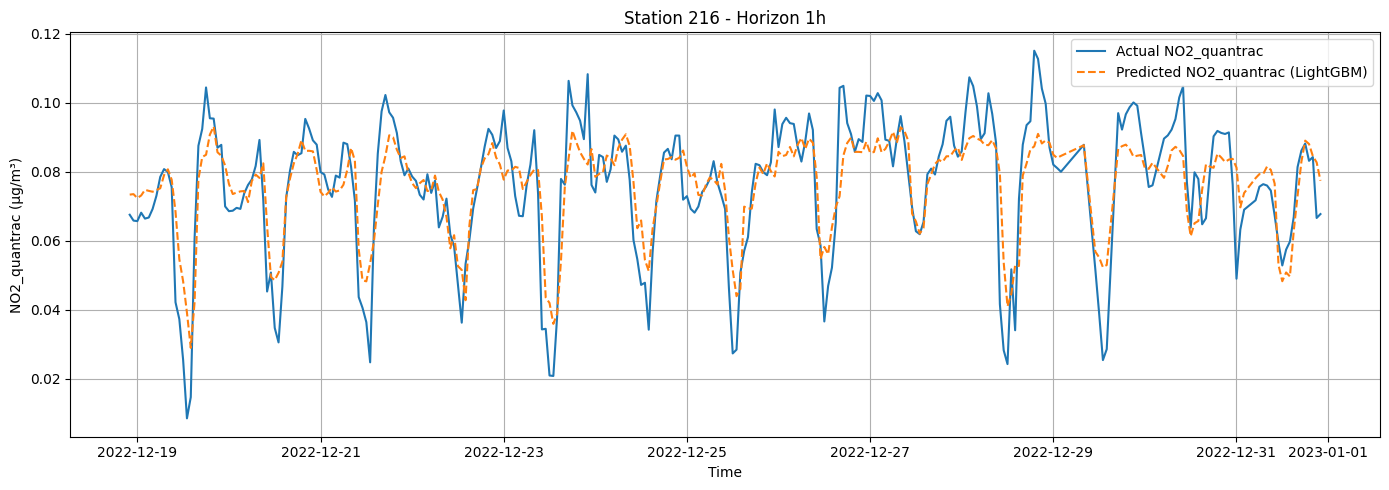

hour = 24
hiepdebug:  914
date          datetime64[ns]
station_id             int64
dtype: object


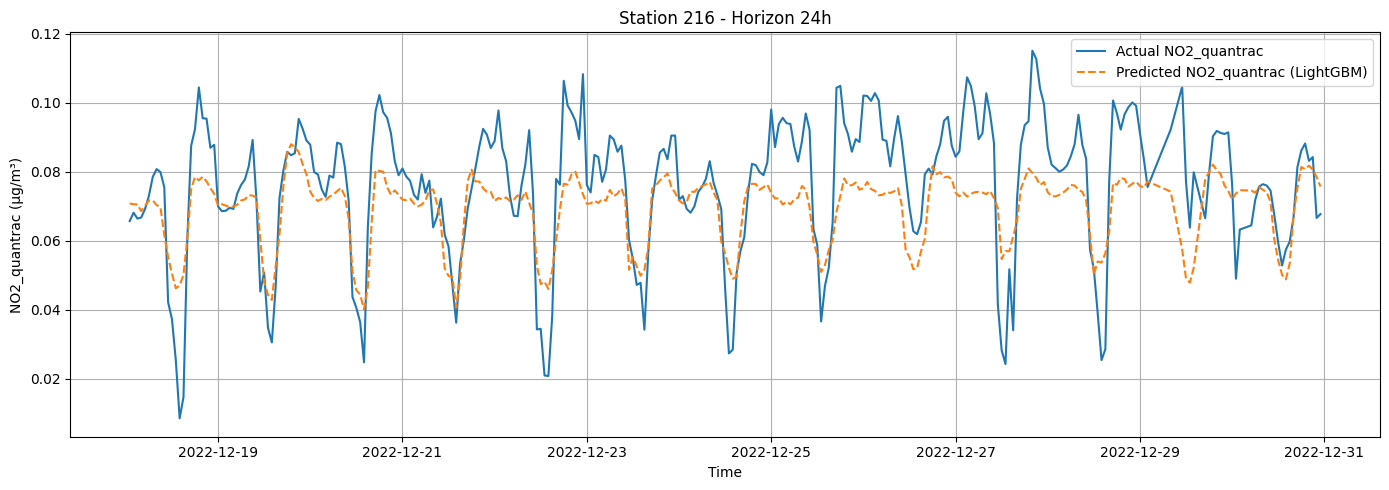

hour = 48
hiepdebug:  884
date          datetime64[ns]
station_id             int64
dtype: object


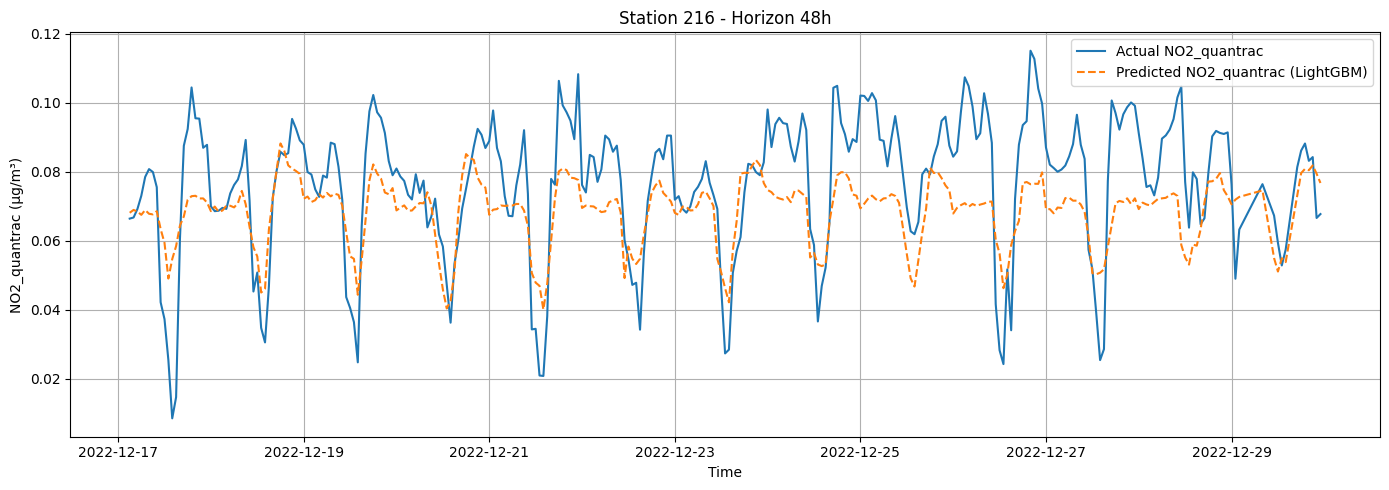

hour = 72
hiepdebug:  870
date          datetime64[ns]
station_id             int64
dtype: object


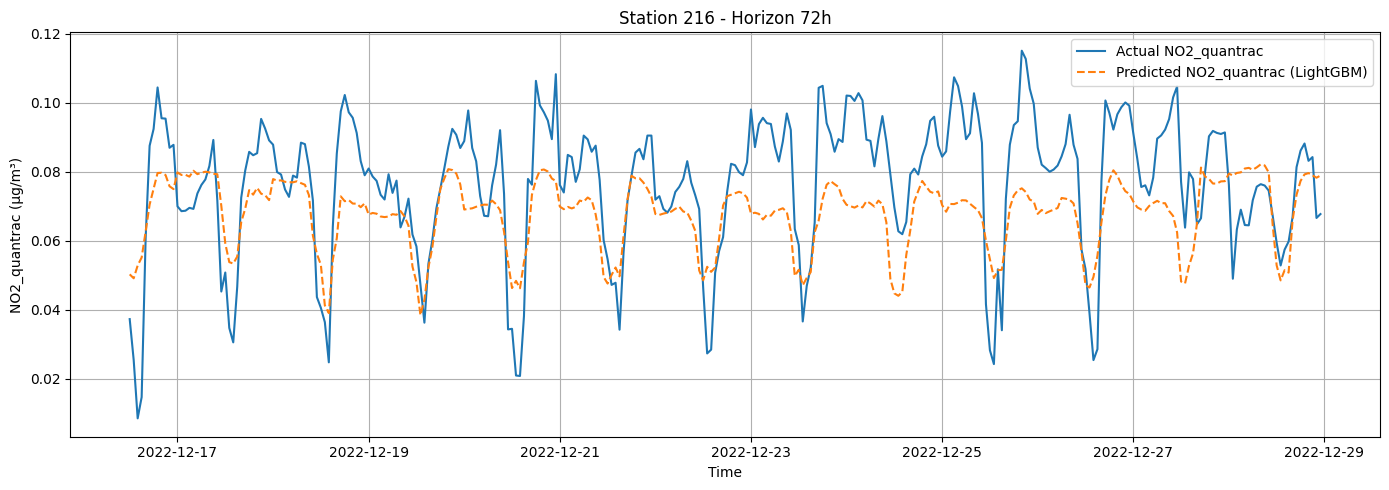

In [10]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in HORIZONS:
        print(f"hour = {hour}")
        plot_timeseries_example(df_no2, no2_models_by_h[hour], horizon_h=hour, station_id=station_id, target_col=label)

## Training for O3

In [11]:
label = "O3_quantrac"

# Add rolling features for LABEL
df_o3 = add_rolling_features(df_all, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)
print(df_o3.columns)

# Start running model
o3_all_metrics = []
o3_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_o3, horizon_h=h, target_col=label)
    o3_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    o3_all_metrics.append(metrics_by_station)

o3_df_metrics_all = pd.concat(o3_all_metrics, ignore_index=True)
o3_df_metrics_all = o3_df_metrics_all.sort_values(["station", "horizon_h"])
o3_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
o3_df_metrics_all

Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'station_id',
       'hour', 'dayofweek', 'month', 'NO2_quantrac_lag1', 'NO2_quantrac_lag2',
       'NO2_quantrac_lag3', 'NO2_quantrac_lag6', 'NO2_quantrac_lag12',
       'NO2_quantrac_lag24', 'NO2_quantrac_lag48', 'NO2_quantrac_lag72',
       'PM25_quantrac_lag1', 'PM25_quantrac_lag2', 'PM25_quantrac_lag3',
       'PM25_quantrac_lag6', 'PM25_quantrac_lag12', 'PM25_quantrac_lag24',
       'PM25_quantrac_lag48', 'PM25_quantrac_lag72', 'O3_quantrac_lag1',
       'O3_quantrac_lag2', 'O3_quantrac_lag3', 'O3_quantrac_lag6',
       'O3_quantrac_lag12', 'O3_quantrac_lag24', 'O3_quantrac_lag48',
       'O3_quantrac_lag72', 'CO_quantrac_lag1', 'CO_quantrac_lag2',
       'CO_quantrac_lag3', 'CO_quantrac_lag6', 'CO_quantrac_lag12',
       'CO_quantrac_lag24', 'CO_quantrac_lag48', 'CO_quantrac_lag72',
       'Temperature_quantrac_lag1', 'Temperature_quantra

,station,horizon_h,RMSE,MAE,MBE,MNBE,r,n_samples
0,216,1,10.612361,7.436851,-1.850682,0.383566,0.831730,968
1,216,24,17.101281,12.096291,-7.061059,-5.651121,0.564406,914
2,216,48,18.211520,13.131782,-8.742998,-8.234417,0.554029,884
3,216,72,20.103456,14.428660,-10.985912,-11.632218,0.477185,870


station_id = 211
hour = 1
hiepdebug:  968
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
hour = 24
hiepdebug:  914
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
hour = 48
hiepdebug:  884
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
hour = 72
hiepdebug:  870
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
station_id = 212
hour = 1
hiepdebug:  968
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 212
hour = 24
hiepdebug:  914
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 212
hour = 48
hiepdebug:  884
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 212
hour = 72
hiepdebug:  870
date          datetime64[ns]
station_id

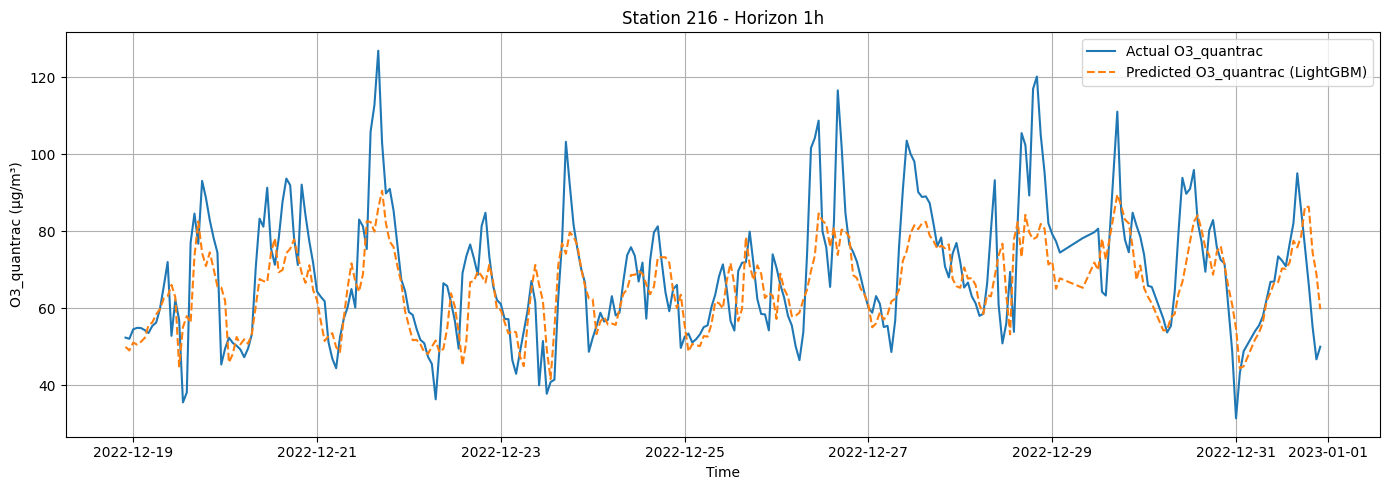

hour = 24
hiepdebug:  914
date          datetime64[ns]
station_id             int64
dtype: object


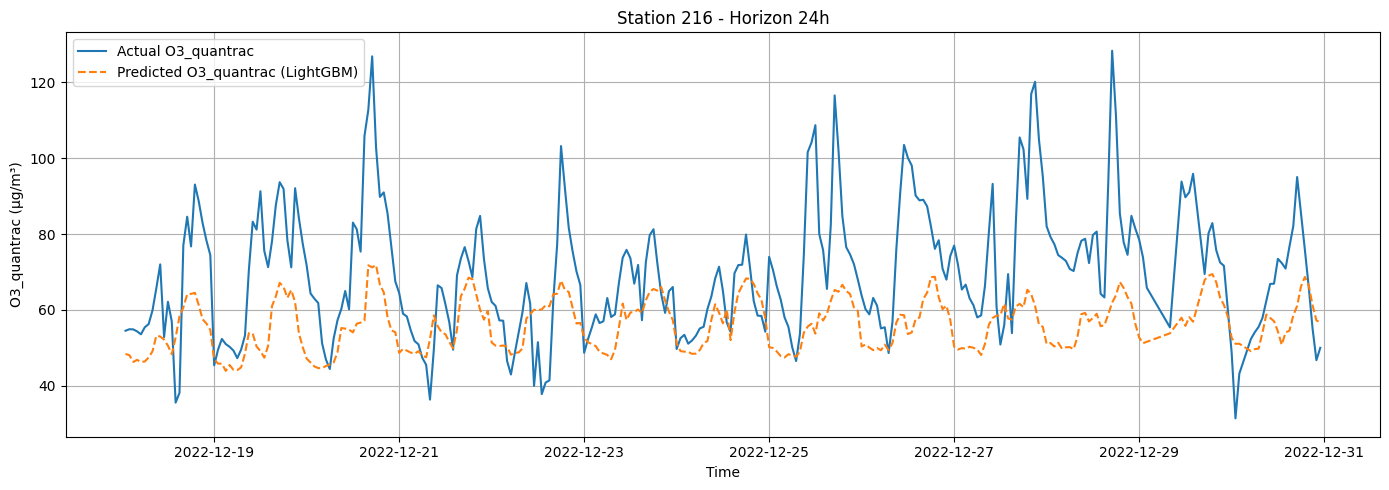

hour = 48
hiepdebug:  884
date          datetime64[ns]
station_id             int64
dtype: object


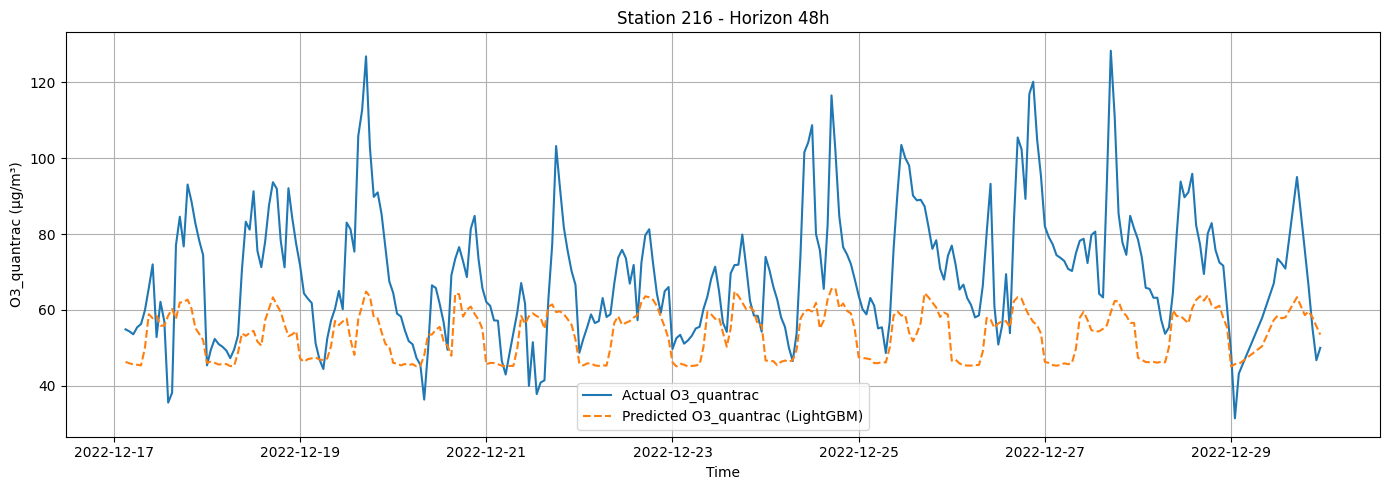

hour = 72
hiepdebug:  870
date          datetime64[ns]
station_id             int64
dtype: object


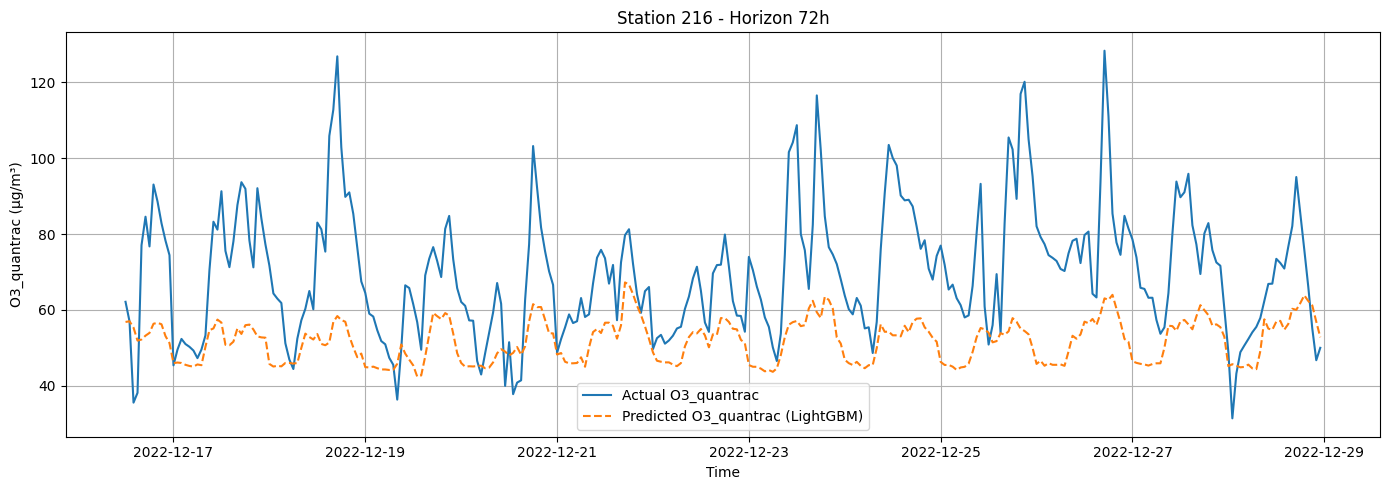

In [12]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in [1, 24, 48, 72]:
        print(f"hour = {hour}")
        plot_timeseries_example(df_o3, o3_models_by_h[hour], horizon_h=hour, station_id=int(station_id), target_col=label)

## Training for CO

In [13]:
label = "CO_quantrac"

# Add rolling features for LABEL
df_co = add_rolling_features(df_all, group_col="station_id", target_cols=[label], windows=ROLL_WINDOWS)
print(df_co.columns)

# Start running model
co_all_metrics = []
co_models_by_h = {}
for h in HORIZONS:
    print(f"\n===== Training LightGBM for horizon = {h}h, target_col = {label} =====")
    model_h, metrics_overall, metrics_by_station, _ = train_lgbm_for_horizon(df_co, horizon_h=h, target_col=label)
    co_models_by_h[h] = model_h
    model_h.save_model(os.path.join(LIGHTGBM_DIR, f"{label}_lightgbm_{h}h"))
    print("Overall test metrics:", metrics_overall)
    co_all_metrics.append(metrics_by_station)

co_df_metrics_all = pd.concat(co_all_metrics, ignore_index=True)
co_df_metrics_all = co_df_metrics_all.sort_values(["station", "horizon_h"])
co_df_metrics_all.to_csv(os.path.join(LIGHTGBM_DIR, f"{label}_metrics.csv"))
co_df_metrics_all

Index(['date', 'NO2_quantrac', 'PM25_quantrac', 'O3_quantrac', 'CO_quantrac',
       'Temperature_quantrac', 'Humid_quantrac', 'SO2_quantrac', 'station_id',
       'hour', 'dayofweek', 'month', 'NO2_quantrac_lag1', 'NO2_quantrac_lag2',
       'NO2_quantrac_lag3', 'NO2_quantrac_lag6', 'NO2_quantrac_lag12',
       'NO2_quantrac_lag24', 'NO2_quantrac_lag48', 'NO2_quantrac_lag72',
       'PM25_quantrac_lag1', 'PM25_quantrac_lag2', 'PM25_quantrac_lag3',
       'PM25_quantrac_lag6', 'PM25_quantrac_lag12', 'PM25_quantrac_lag24',
       'PM25_quantrac_lag48', 'PM25_quantrac_lag72', 'O3_quantrac_lag1',
       'O3_quantrac_lag2', 'O3_quantrac_lag3', 'O3_quantrac_lag6',
       'O3_quantrac_lag12', 'O3_quantrac_lag24', 'O3_quantrac_lag48',
       'O3_quantrac_lag72', 'CO_quantrac_lag1', 'CO_quantrac_lag2',
       'CO_quantrac_lag3', 'CO_quantrac_lag6', 'CO_quantrac_lag12',
       'CO_quantrac_lag24', 'CO_quantrac_lag48', 'CO_quantrac_lag72',
       'Temperature_quantrac_lag1', 'Temperature_quantra

,station,horizon_h,RMSE,MAE,MBE,MNBE,r,n_samples
0,216,1,0.492157,0.327404,-0.105203,0.779852,0.772901,968
1,216,24,0.627818,0.442288,-0.168397,3.626966,0.584408,914
2,216,48,0.664057,0.456042,-0.245390,-2.128199,0.568518,884
3,216,72,0.717147,0.488378,-0.328942,-8.251560,0.539375,870


station_id = 211
hour = 1
hiepdebug:  968
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
hour = 24
hiepdebug:  914
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
hour = 48
hiepdebug:  884
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
hour = 72
hiepdebug:  870
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 211
station_id = 212
hour = 1
hiepdebug:  968
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 212
hour = 24
hiepdebug:  914
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 212
hour = 48
hiepdebug:  884
date          datetime64[ns]
station_id             int64
dtype: object
No test sample for station 212
hour = 72
hiepdebug:  870
date          datetime64[ns]
station_id

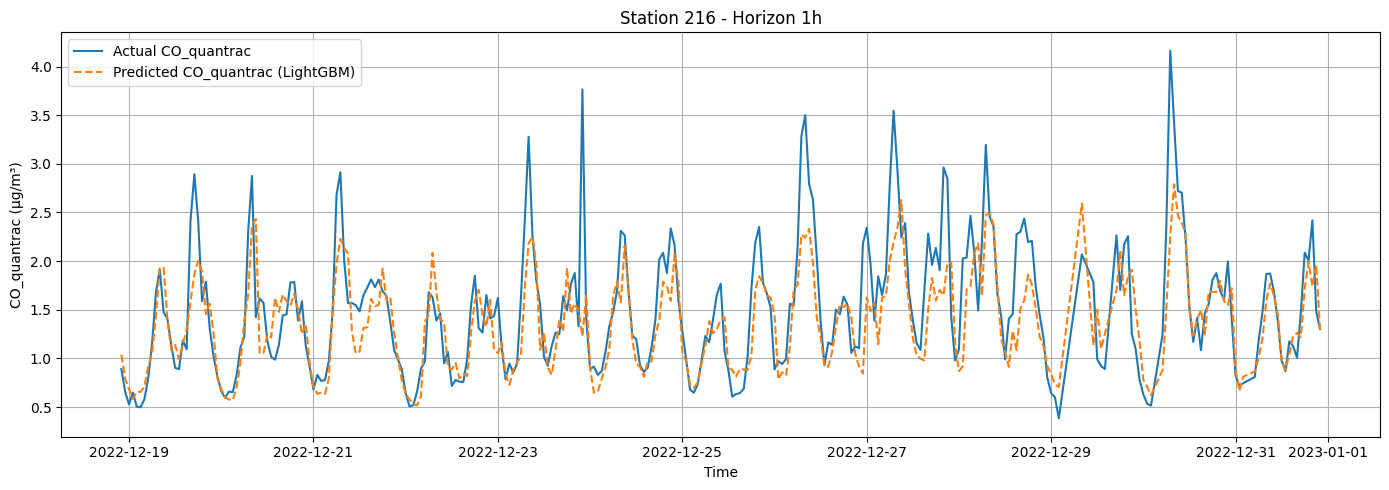

hour = 24
hiepdebug:  914
date          datetime64[ns]
station_id             int64
dtype: object


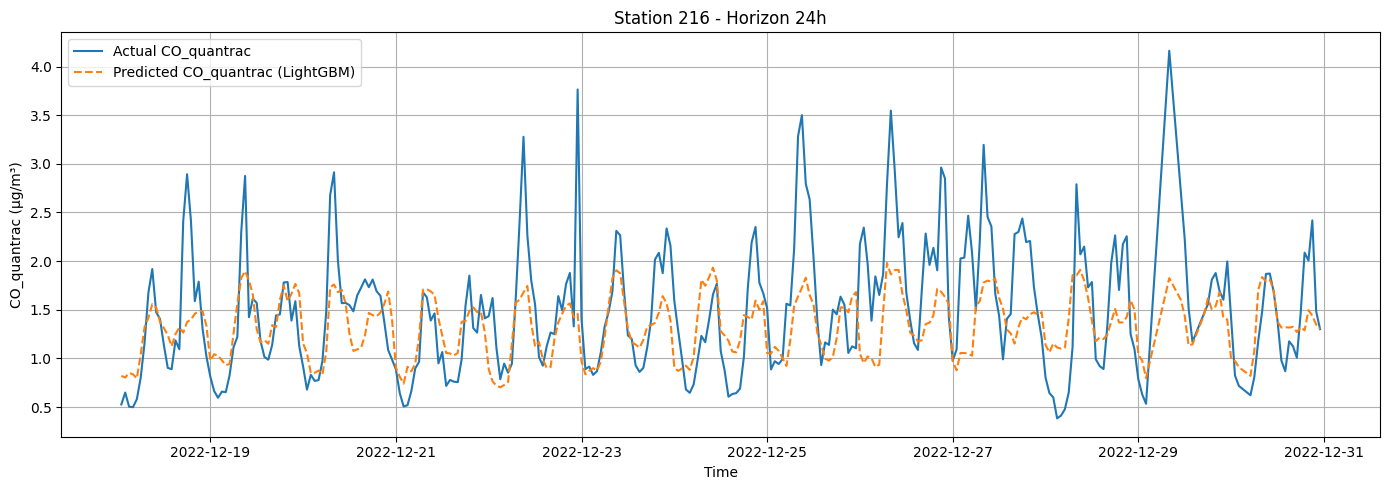

hour = 48
hiepdebug:  884
date          datetime64[ns]
station_id             int64
dtype: object


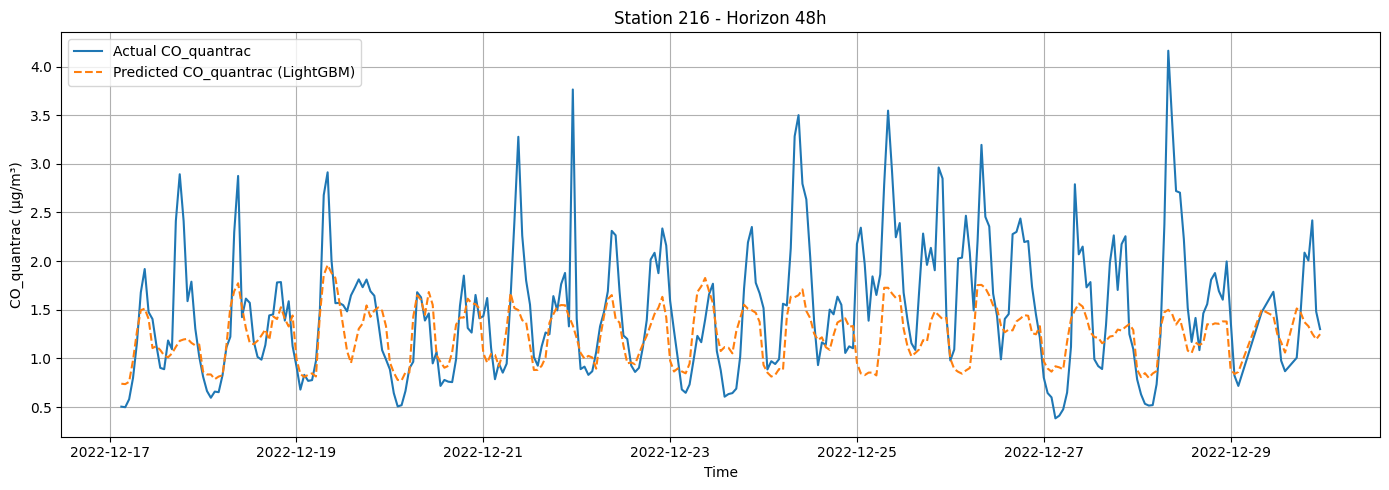

hour = 72
hiepdebug:  870
date          datetime64[ns]
station_id             int64
dtype: object


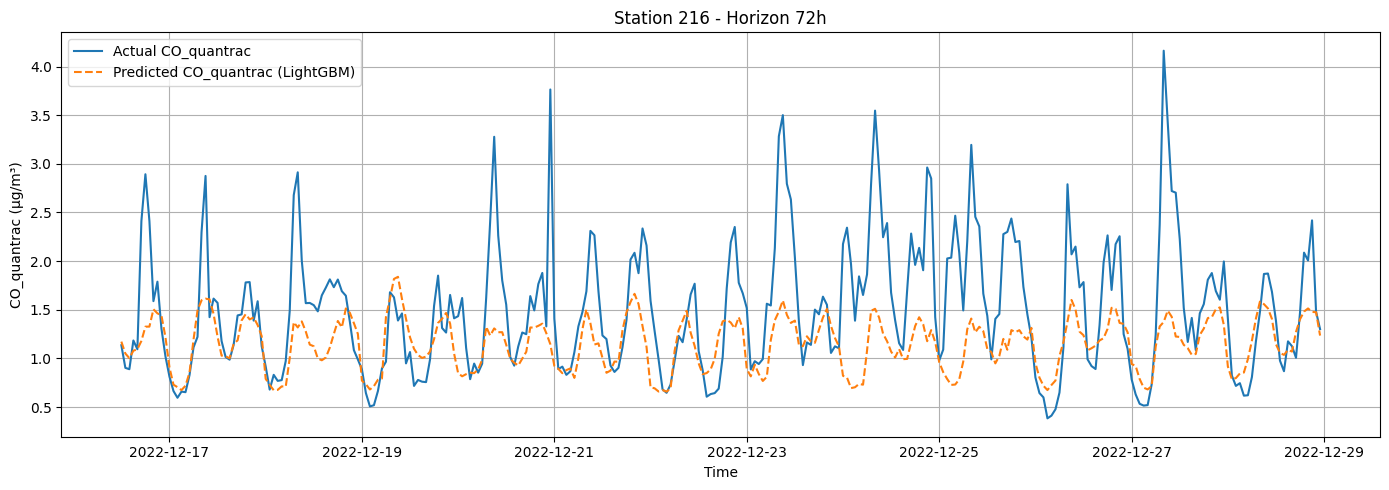

In [14]:
# Reference
for station_id in STATION_IDS:
    print(f"station_id = {station_id}")
    for hour in [1, 24, 48, 72]:
        print(f"hour = {hour}")
        plot_timeseries_example(df_co, co_models_by_h[hour], horizon_h=hour, station_id=int(station_id), target_col=label)